In [1]:
import warnings
warnings.simplefilter('ignore')

# Import XGBoost
import xgboost

# XGBoost Classifier
from xgboost import XGBClassifier

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Yahoo finance to get the data
from pandas_datareader import data

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn

# For data manipulation
import pandas as pd
import numpy as np

In [2]:
# Set the stock list
stock_list = ['AAPL', 'AMZN', 'NFLX', 'NVDA','MSFT']

# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2021-12-10'

In [3]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [4]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    
    # Get the data    
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()

    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)

    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})
    

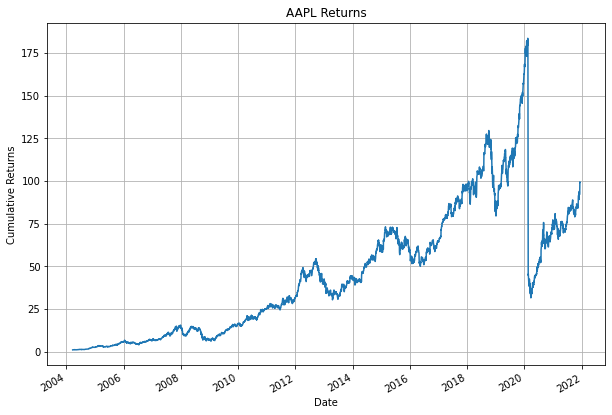

In [5]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['AAPL'].daily_pct_change+1).cumprod().plot()

# Set the title and axis lables and plot grid
plt.title('AAPL Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [6]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal

    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [7]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

XGBClassifier(max_depth=2, n_estimators=30)

In [8]:
X = [k for k in range(0, 7)] # create array with numbers ranging from 0 to 7
y = X # just for testing

# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7,shuffle=True )

# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) 

Accuracy: 51.26% (0.57%)


In [9]:
# Fit the model
model.fit(X_train, y_train)

XGBClassifier(max_depth=2, n_estimators=30)

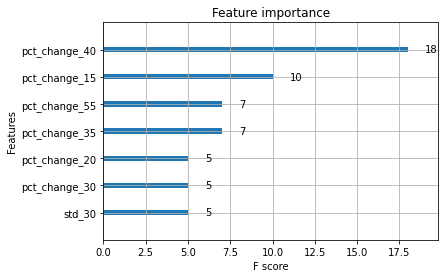

In [10]:
# Plot the top 7 features
xgboost.plot_importance(model, max_num_features=7)

# Show the plot
plt.show()

In [11]:
# Predict the trading signal on test datset
y_pred = model.predict(X_test)

In [12]:
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.08      0.14      2050
           1       0.54      0.93      0.69      2415

    accuracy                           0.54      4465
   macro avg       0.51      0.50      0.41      4465
weighted avg       0.52      0.54      0.43      4465



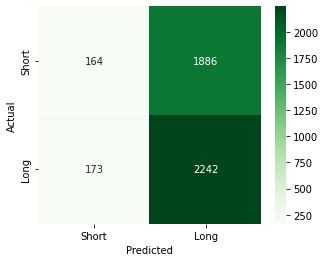

In [13]:
array = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
                  'Short', 'Long'])

plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AAPL


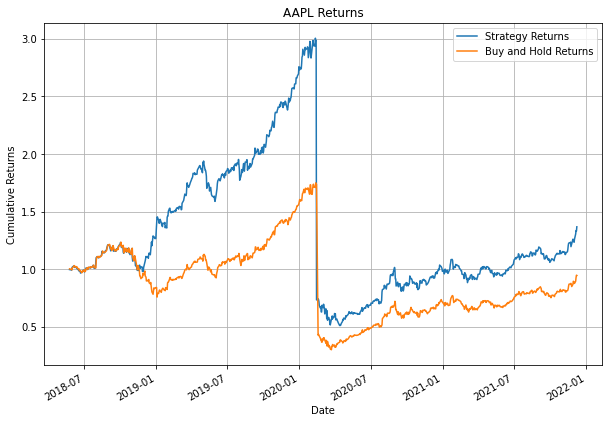

AMZN


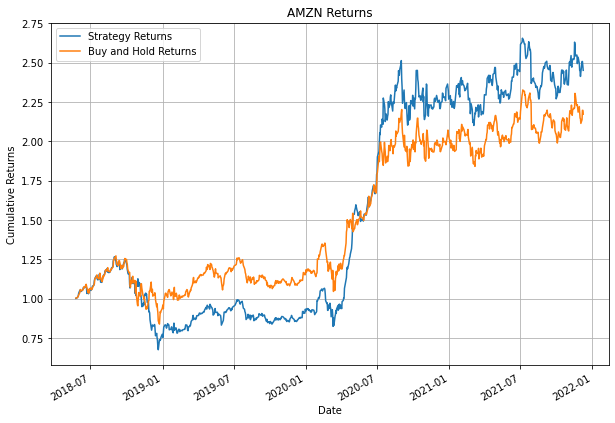

NFLX


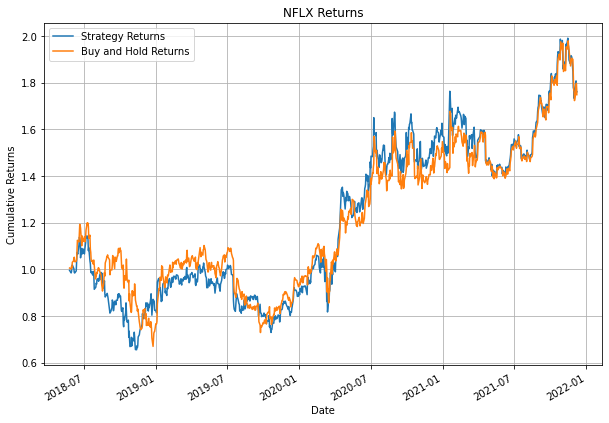

NVDA


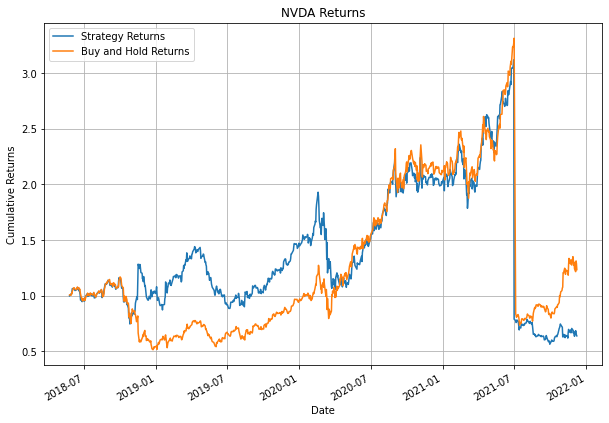

MSFT


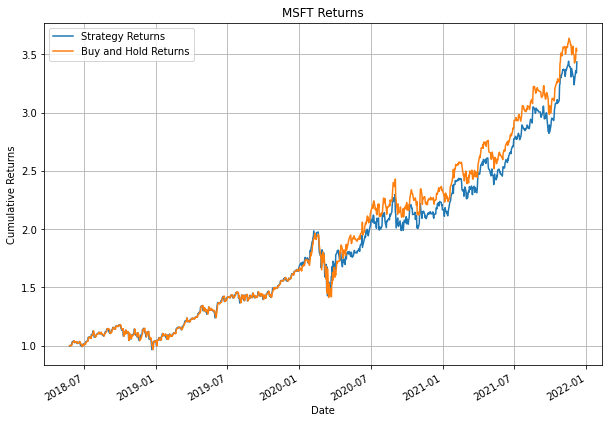

In [14]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)

# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]

    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal

    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    
    # Set the figure size
    plt.figure(figsize=(10, 7))
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

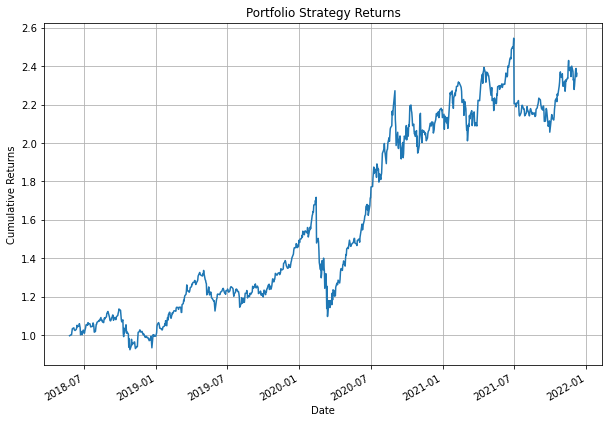

In [15]:
# Drop missing values
portfolio.dropna(inplace=True)

# Set the figure size
plt.figure(figsize=(10, 7))

# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()

# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [16]:
pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-0jrue6ww
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-0jrue6ww


Start date,2018-05-25
End date,2021-12-09
Total months,42
,Backtest
Annual return,27.462%
Cumulative returns,136.281%
Annual volatility,29.574%
Sharpe ratio,0.97
Calmar ratio,0.76
Stability,0.90
Max drawdown,-36.115%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.11,2020-02-13,2020-03-13,2020-07-02,101
1,19.21,2021-07-01,2021-10-01,NaT,NaN
2,18.67,2018-09-28,2018-10-26,2019-02-21,105
3,15.80,2019-05-02,2019-05-31,2019-11-15,142
4,15.62,2020-09-01,2020-09-17,2021-02-03,112


Stress Events,mean,min,max
New Normal,0.11%,-13.84%,10.14%


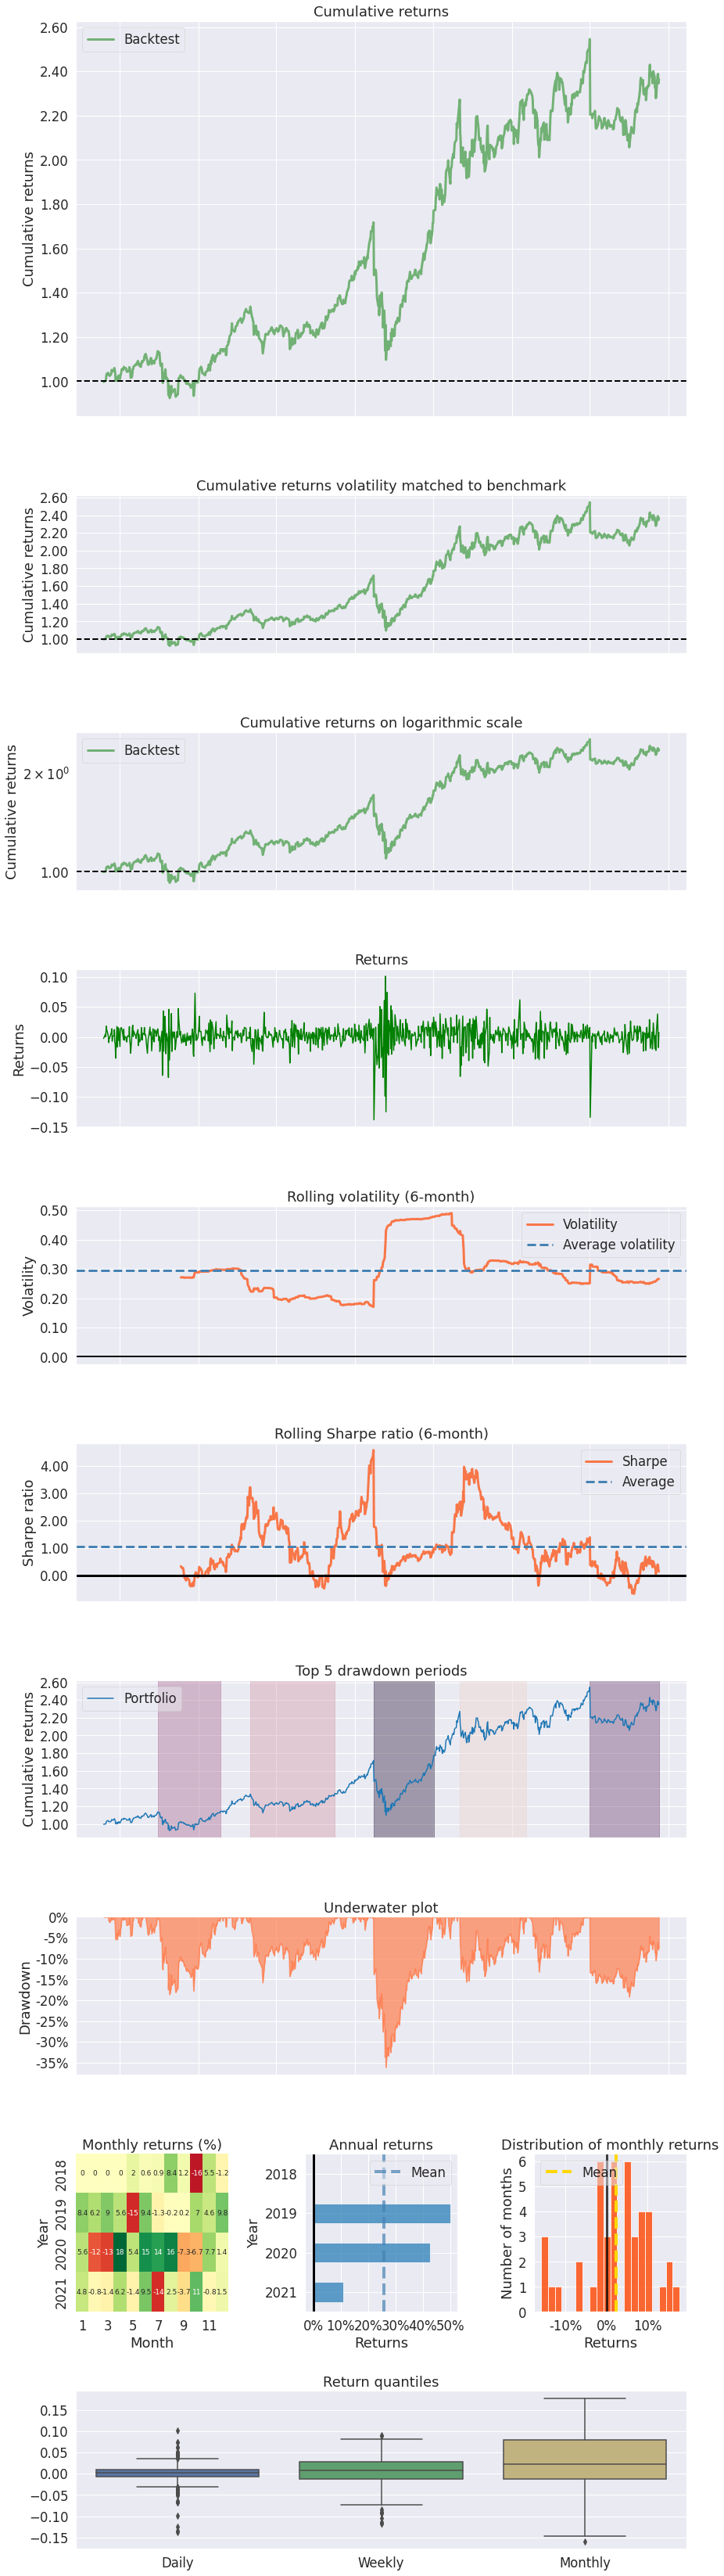

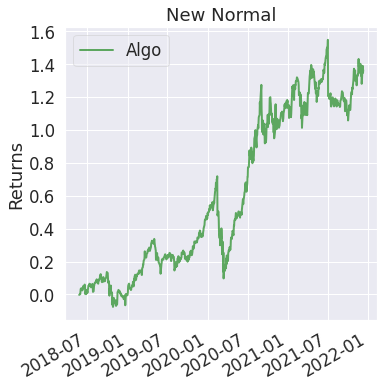

In [17]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))